# Big query sql

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 4.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=e7bf635619a379f31c3f4713ac8c841433b9a2936c9c19fb61b259dbc4fdc9d5
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [2]:
import pandas as pd, matplotlib.pyplot as plt
import japanize_matplotlib

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from getpass import getpass
pjt_code = getpass('ProjectCode: ')

ProjectCode: ··········


In [5]:
# slack開始日取得
%%bigquery --project {pjt_code} df_min_date
SELECT MIN(target_date)
FROM mgm.talk
WHERE target_date > "1990-01-01"

In [6]:
min_date = df_min_date.iloc[0,0]

In [ ]:
# 週毎のチャンネル数
%%bigquery --project {pjt_code} df_channel_count
SELECT
  DATE_TRUNC(target_date, WEEK(SUNDAY)) as week,
  count(DISTINCT id) AS channel_cnt
FROM
  mgm.channel
WHERE
  target_date >= "2019-06-01" --過去30日以内のデータを選定
GROUP BY 1
ORDER BY 1

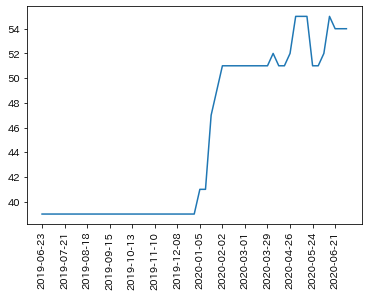

In [ ]:
plt.clf()
plt.plot(df_channel_count.channel_cnt)
plt.xticks(ticks = range(0,len(df_channel_count),4),labels=df_channel_count.week[::4], rotation = 90)
plt.show()

In [7]:
# Channel毎の発言数・リアクション数（7月時点の残存チャンネル）
%%bigquery --project {pjt_code} df_channel_talk_reaction_count
WITH talk_count AS (
  SELECT
    channel_id, COUNT(*) AS talk_count, MIN(target_date) AS min_date, MAX(target_date) AS max_date
  FROM
    mgm.talk
  WHERE
--      target_date >= "2019-07-01" AND target_date <= "2020-06-30"
    target_date >= "2019-01-01"
  GROUP BY channel_id
),
reaction_count AS (
  SELECT
    channel_id, COUNT(*) AS reaction_count
  FROM
    mgm.reaction
  WHERE
--      target_date >= "2019-07-01" AND target_date <= "2020-06-30"
    target_date >= "2019-01-01"
  GROUP BY channel_id
),
channel_name AS (
  SELECT
    DISTINCT id, name AS channel_name
  FROM
    mgm.channel
  WHERE
--      target_date >= "2019-07-01" AND target_date <= "2020-06-30"
    target_date >= "2020-07-01"
)

SELECT
  t.channel_id, c.channel_name, t.talk_count, r.reaction_count, r.reaction_count/t.talk_count AS reaction_ratio,
  t.min_date, t.max_date
FROM
  channel_name c
INNER JOIN
  talk_count t
ON
  c.id = t.channel_id
INNER JOIN
  reaction_count r
ON
  c.id = r.channel_id
ORDER BY channel_name

In [8]:
# 重複カウントチャンネル確認
df_dup_chn_cnt = df_channel_talk_reaction_count.groupby('channel_id').count()['channel_name'].reset_index(drop=False)
df_dup_chn_cnt[df_dup_chn_cnt['channel_name']>1]

,channel_id,channel_name


In [9]:
df_channel_talk_reaction_count['total_talk_ratio'] = df_channel_talk_reaction_count['talk_count'] / df_channel_talk_reaction_count['talk_count'].sum()
df_channel_talk_reaction_count.sort_values(by='talk_count', ascending=False, inplace = True, ignore_index= True)
df_channel_talk_reaction_count['cum_total_talk_ratio'] = df_channel_talk_reaction_count['total_talk_ratio'].cumsum()


<Figure size 432x288 with 0 Axes>

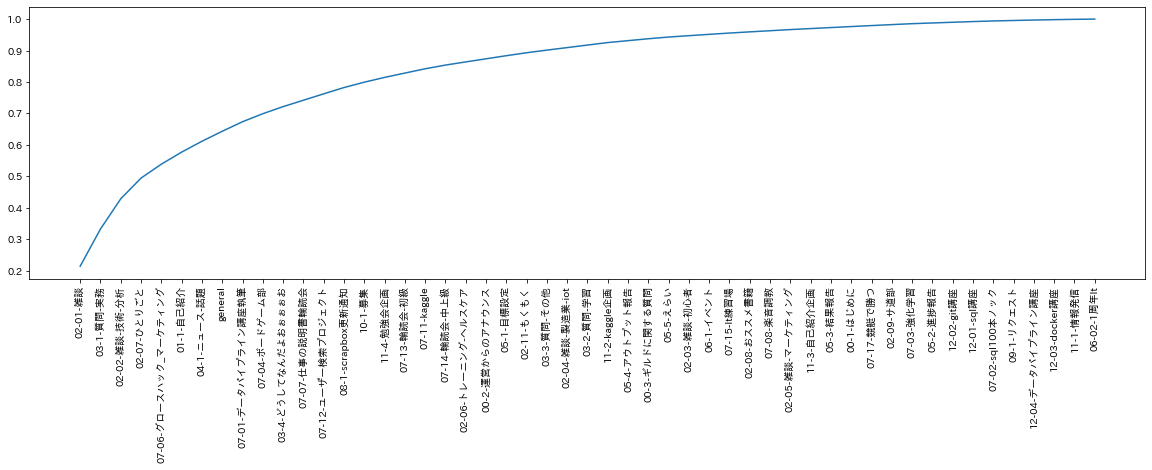

In [ ]:
plt.clf()
plt.figure(figsize=(20,5))
plt.plot(df_channel_talk_reaction_count['channel_name'], df_channel_talk_reaction_count['cum_total_talk_ratio'])
plt.xticks(rotation=90)
plt.show()

<Figure size 432x288 with 0 Axes>

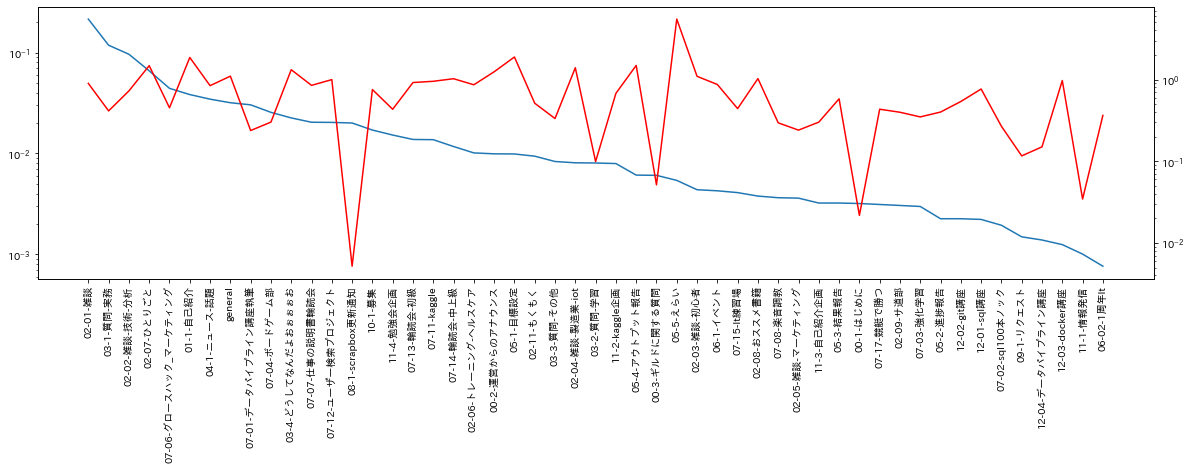

In [ ]:
# チャンネルごとのトーク割合とリアクション比率
df_plt = df_channel_talk_reaction_count[df_channel_talk_reaction_count['talk_count']>=10].copy()
plt.clf()
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(range(len(df_plt)),df_plt['total_talk_ratio'], label='total_talk_ratio')
ax1.set_yscale('log')
ax2=ax1.twinx()
ax2.plot(range(len(df_plt)),df_plt['reaction_ratio'], label = 'reaction/talk ratio', color = 'red')
ax2.set_yscale('log')
ax1.set_xticks(ticks=range(len(df_plt)))
ax1.set_xticklabels(df_plt['channel_name'], rotation=90)
# plt.legend(loc='best')
plt.show()

In [10]:
# Channel毎の発言数・メンション数（7月時点の残存チャンネル）
%%bigquery --project {pjt_code} df_channel_talk_mention_count
WITH talk_count AS (
  SELECT
    channel_id, COUNT(*) AS talk_count
  FROM
    mgm.talk
  WHERE
    target_date >= "2019-01-01"
  GROUP BY channel_id
),
mention_count AS (
  SELECT
    channel_id, COUNT(*) AS mention_count
  FROM
    mgm.mention
  WHERE
    target_date >= "2019-01-01"
  GROUP BY channel_id
),
channel_name AS (
  SELECT
    DISTINCT id, name AS channel_name
  FROM
    mgm.channel
  WHERE
    target_date >= "2020-07-01"
)

SELECT
  t.channel_id, c.channel_name, t.talk_count, m.mention_count, m.mention_count/t.talk_count AS mention_ratio
FROM
  channel_name c
INNER JOIN
  talk_count t
ON
  c.id = t.channel_id
INNER JOIN
  mention_count m  
ON
  c.id = m.channel_id
ORDER BY channel_name

In [11]:
df_dup_chn_cnt = df_channel_talk_mention_count.groupby('channel_id').count()['channel_name'].reset_index(drop=False)
df_dup_chn_cnt[df_dup_chn_cnt['channel_name']>1]

,channel_id,channel_name


In [12]:
df_channel_talk_mention_count['talk_count'].sum()

30770

In [13]:
df_channel_talk_mention_count['total_talk_ratio'] = df_channel_talk_mention_count['talk_count'] / df_channel_talk_mention_count['talk_count'].sum()
df_channel_talk_mention_count.sort_values(by='talk_count', ascending=False, inplace = True, ignore_index= True)
df_channel_talk_mention_count['cum_total_talk_ratio'] = df_channel_talk_mention_count['total_talk_ratio'].cumsum()

In [ ]:
(df_channel_talk_mention_count.sort_values(by = ['talk_count'], ascending=False)['talk_count']*-1).hist(bins = 100,cumulative=True)

In [ ]:
df_channel_talk_mention_count.sort_values(by='total_talk_ratio', ascending=False, inplace = True)

<Figure size 432x288 with 0 Axes>

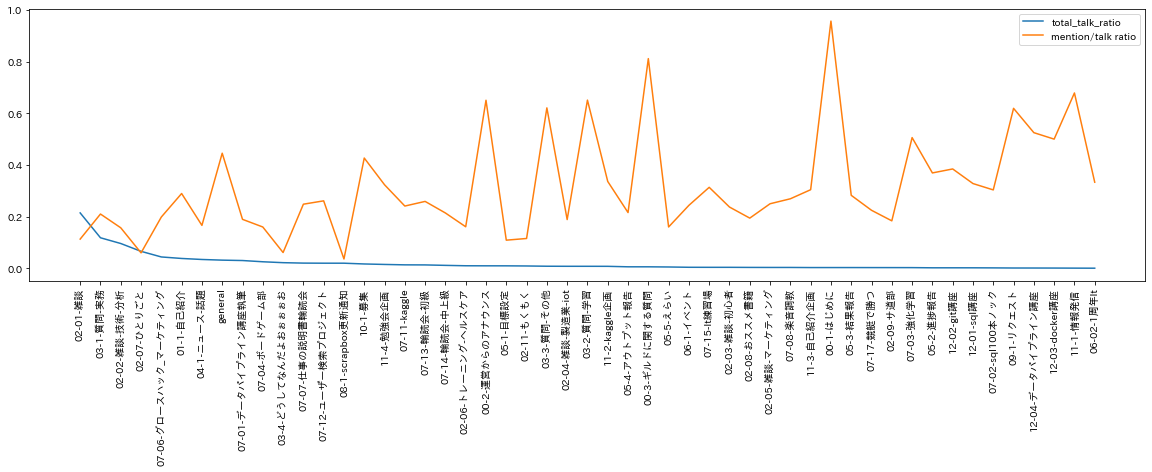

In [ ]:
df_plt = df_channel_talk_mention_count[df_channel_talk_mention_count['talk_count']>=10].copy()
plt.clf()
plt.figure(figsize=(20,5))
plt.plot(range(len(df_plt)),df_plt['total_talk_ratio'], label='total_talk_ratio')
plt.plot(range(len(df_plt)),df_plt['mention_ratio'], label = 'mention/talk ratio')
plt.xticks(ticks=range(len(df_plt)), labels=df_plt['channel_name'], rotation=90)
plt.legend(loc='best')
plt.show()

In [ ]:
# replies_historyテーブル確認
%%bigquery --project {pjt_code} df_replies_history
SELECT
  target_date, COUNT(*)
FROM
 mgm.replies_history
WHERE
  target_date > "2020-01-01"
GROUP BY target_date
ORDER BY target_date

In [ ]:
# 2020-04-01時点でデータ更新が停止されている
df_replies_history

,target_date,f0_
0,2020-01-02,44
1,2020-01-04,121
2,2020-01-05,63
3,2020-01-06,152
4,2020-01-07,214
...,...,...
85,2020-03-28,266
86,2020-03-29,230
87,2020-03-30,94
88,2020-03-31,177


In [ ]:
# ユーザ別トーク数
%%bigquery --project {pjt_code} df_user_talk_cnt
SELECT
  talk_user, COUNT(DISTINCT talk_id) AS talk_count
FROM
  mgm.talk
WHERE target_date > "2019-06-01"
GROUP BY talk_user

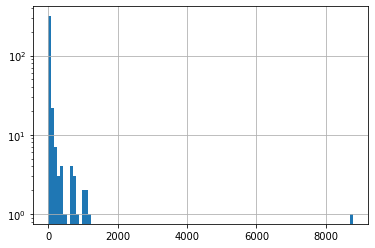

In [ ]:
df_user_talk_cnt['talk_count'].hist(bins = 100, log=True)

In [ ]:
df_user_talk_cnt.sort_values(by = 'talk_count', ascending=False)

,talk_user,talk_count
235,UJRAL005U,8773
11,UN0HCK74M,1151
126,US69FTTH6,1108
123,UKT5BQD3P,1101
5,UL2TY2ERL,1053
...,...,...
194,URWLSTTCH,1
117,USHRYKMED,1
109,U015AU2NDB3,1
105,UTHR2UNGY,1
